# C-CORE Iceberg Classifier Challenge 커널 리뷰!

14기 임형우

## 대회 소개
대회 링크: https://www.kaggle.com/c/statoil-iceberg-classifier-challenge/overview

#### 대회에 대한 간략한 소개:
북해에서 항해를 하다보면 맞닥드리는 제일 위험한 상황은 표류하는 빙하와의 충돌이다. 이 문제에 대해 골머리를 앓고 있던 에너지 회사인 Statoil사는 위성 회사인 C-CORE와 협력을 하여 표류 빙하와 일반적인 배의 위성 사진을 분류하는 모델을 만들기 위해 이 대회를 개최하게 되었다.
<br>
<br>

#### 데이터 소개
데이터는 지상 600km에 위치한 위성에서 레이더를 쏴 반사된 빛을 이용해 이미지화(backscatter)한 것이라 한다. 물체가 견고할수록(land, islands, sea ice, icebergs, ships) 더 강한 레이더 에너지가 반사되어 실제 이미지에서 더 밝게 나온다고 하며, 이 원리로 바다에 떠있는 견고한 물체인 배나 빙하를 식별할 수 있다고 한다. 레이더는 수직, 수평 두 방향으로 쏘는데, 각 방향으로 생성된 이미지는 band_1, band_2에 저장되어있다. <br>
![HH_HV](img/HH_HV_diff.png)
<br>
<br>

##### 데이터의 Features:
1. id : 이미지 id
2. band_1, band_2 : 레이더 1, 2에서 backscatter로 생성된 이미지 데이터이며 2차원 데이터를 1차원으로 flatten한 데이터
3. inc_angle : 이미지가 찍한 각도
4. is_iceberg : 1 = 빙하, 0 = 배 를 나타내는 Target 변수
<br>
<br>

#### 채점 방식
Log Loss (cross entropy) 사용

## 커널 개요

1. 이미지 데이터 EDA 및 전처리
<br>
2. Plotly 이용 데이터 시각화
<br>
3. TensorFlow-Keras의 딥러닝 모듈을 사용해 CNN 모델 학습

## 필사 시작
커널 링크: https://www.kaggle.com/sh0wmaker/binary-image-classification

### 필요한 패키지 설치 및 데이터 불러오기

In [ ]:
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from matplotlib import pyplot as plt

%matplotlib inline 
# 노트북에 바로 결과로 그림이 나오도록 하는 세팅
plt.rcParams['figure.figsize'] = 8, 5  # 디폴트로 Figure 사이즈를 정해주는 코드

# Iceberg Visualization Tools
import plotly.offline as py # Plotly.online도 존재하지만, 우리는 사진들을 Plotly Cloud를 사용안할 예정이라서
import plotly.graph_objs as go # offline 사용. 
from plotly import tools #그림을 그릴때 보조도구 (e.g. subplot 만들기)

#Ignore warnings
import warnings 
warnings.filterwarnings('ignore')

# plotly를 jupyter notebook에 사용하려면 *반드시* 이 커맨드를 입력해야 합니다.
py.init_notebook_mode(connected=True) 

데이터가 json형태라서 자주 사용하던 pd.read_csv가 아니라 pd.read_json으로 읽을 수 있음
<br>
또한 이번 파일은 7z형태로 되어있어서 미리 압축을 풀어주도록 한다
<br>

In [ ]:
train = pd.read_json('data/train.json')
test = pd.read_json('data/test.json')

### EDA 및 데이터 전처리

In [ ]:
train.head(5)

,id,band_1,band_2,inc_angle,is_iceberg
0,dfd5f913,"[-27.878360999999998, -27.15416, -28.668615, -...","[-27.154118, -29.537888, -31.0306, -32.190483,...",43.9239,0
1,e25388fd,"[-12.242375, -14.920304999999999, -14.920363, ...","[-31.506321, -27.984554, -26.645678, -23.76760...",38.1562,0
2,58b2aaa0,"[-24.603676, -24.603714, -24.871029, -23.15277...","[-24.870956, -24.092632, -20.653963, -19.41104...",45.2859,1
3,4cfc3a18,"[-22.454607, -23.082819, -23.998013, -23.99805...","[-27.889421, -27.519794, -27.165262, -29.10350...",43.8306,0
4,271f93f4,"[-26.006956, -23.164886, -23.164886, -26.89116...","[-27.206915, -30.259186, -30.259186, -23.16495...",35.6256,0


In [ ]:
#train, test set의 크기 확인
print('Shape of train set:', train.shape)
print('Shape of test set:', test.shape)

Shape of train set: (1604, 5)
Shape of test set: (8424, 4)


In [ ]:
# 'inc_angle' 특성에서 등장하는 모든 값들과 그 값들의 빈도수를 보자
train['inc_angle'].value_counts() # value_counts() : '리스트'를 받으면 등장하는 모든 값과 그 값들의 빈도수를 보여줌

na         133
34.4721     23
42.5591     16
33.6352     15
36.1061     15
          ... 
30.4373      1
24.7546      1
40.3085      1
37.1941      1
35.7139      1
Name: inc_angle, Length: 879, dtype: int64

In [ ]:
#na값을 모두 0으로 바꿔주는 작업
train.inc_angle = train.inc_angle.replace('na',0) #arr.replace(a, b) : arr 리스트에 등장하는 모든 a값을 b값으로 변경
                                                  # 그 다음 반환된 변경된 리스트를 원래 리스트 reference?인 'train.inc_angle'로 저장

In [ ]:
#다른 모든 항은 float형으로 이루어져 있기 때문에 replace해준 값들도 모두 float로 바꿔야함
train.inc_angle = train.inc_angle.astype(float).fillna(0.0) #arr.astype(type) : 리스트의 모든 아이템을 type 타입으로 parse함

In [ ]:
len(train.loc[0,'band_1'])

# 이 데이터를 가지고 학습하거나 Plot하기 편하려면 numpy array로 바꾸는게 좋음
# 이미지이기 때문에 이미지 형태로 바꿔주면 좋음
# 75x75 = 5625이므로 학습하기 좋게 하기 위해서 사이즈를 75x75사이즈로 바꾸자

5625

In [ ]:
X_band_1 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_1']]);
# 'band_1' 특성에 있는 모든 아이템에 대해 np.float32으로 타입을 바꿔주고, reshape함수를 사용해 
# 5625크기의 1차원 리스트를 -> 75 X 75 크기의 2차원 리스트로 변경 (5625 = 75 X 75)
X_band_2 = np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in train['band_2']]);
# 'band_2' 특성에 대해서도 동일하게 적용

In [ ]:
# np.concatenate((arr1, arr2), axis) : axis값에 따라 특정한 축으로 두개의 numpy array를 concatenate해줌
a = np.array([[1, 2], [3, 4]])
b = np.array([[7, 8], [9, 10], [11, 12]])

print(np.concatenate((a, b), axis=0))
print(np.concatenate((a, b.T), axis=1))
print(np.concatenate((a, b), axis=None))

[[ 1  2]
 [ 3  4]
 [ 7  8]
 [ 9 10]
 [11 12]]
[[ 1  2  7  9 11]
 [ 3  4  8 10 12]]
[ 1  2  3  4  7  8  9 10 11 12]


In [ ]:
# 2D CNN학습을 위해서 [N, height, width, channel]의 차원을 가지도록 데이터 가공하는 작업
# 채널이란 RGB에서 말하는 채널을 생각하면 편함 (이미지화 하기 위해 필요한 차원이라고 생각하면 됨)
# 차원을 늘려줄때 np.newaxis를 사용하면 쉽게 사용 가능하다.
# np.newawis : 단순하게 numpy array의 차원을 늘려주는 것 (== None) (e.g. 1D -> 2D, 2D -> 3D, ...)

X_train = np.concatenate([X_band_1[:, :, :, np.newaxis], # 채널 1 
                          X_band_2[:, :, :, np.newaxis], # 채널 2
                          ((X_band_1+X_band_2)/2)[:, :, :, np.newaxis]], # 채널 3
                         axis=-1) # 제일 마지막 차원 기준으로 concatenate 실행

In [ ]:
# np.concatenate 함수 이해를 위한 셀
print(X_band_1[:, :, :, np.newaxis].shape)
print(X_band_2[:, :, :, np.newaxis].shape)

print(np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=0).shape)
print(np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=1).shape)
print(np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=2).shape)
print(np.concatenate([X_band_1[:, :, :, np.newaxis], X_band_2[:, :, :, np.newaxis]], axis=-1).shape)
# 각 채널의 값을 채워주는 것이기 때문에 마지막 차원을 기준으로 concatenate를 진행하는 것

(1604, 75, 75, 1)
(1604, 75, 75, 1)
(3208, 75, 75, 1)
(1604, 150, 75, 1)
(1604, 75, 150, 1)
(1604, 75, 75, 2)


In [ ]:
# Test 데이터셋에도 동일하게 적용!
X_band_test_1=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_1"]])
X_band_test_2=np.array([np.array(band).astype(np.float32).reshape(75, 75) for band in test["band_2"]])
X_test = np.concatenate([X_band_test_1[:, :, :, np.newaxis]
                          , X_band_test_2[:, :, :, np.newaxis]
                         , ((X_band_test_1+X_band_test_2)/2)[:, :, :, np.newaxis]], axis=-1)

### 데이터 시각화

In [ ]:
#시각화 예시, 예로 14번 추출 값이 0, 즉 이것은 ship이다 
train.loc[14, 'is_iceberg']

0

In [ ]:
# Plotly 3D 시각화의 기본적인 예시
c, name = X_band_1[14, :, :], 'Ship' # c에 14번 데이터 저장

data = [go.Surface(z = c)] # z축값을 c의값으로 설정
layout = go.Layout() # 레이아웃 세팅

fig = go.Figure(data=data, layout=layout)
py.iplot(fig) #Same as plt.show()

In [ ]:
label = 'ship'

#같은 14번 ship이지만 보는 각에 따라서 나오는 것이 다르다는 것을 보여주는 것 
band1 = X_band_1[14,:,:]
band2 = X_band_2[14,:,:]

#matplotlib의 subplot처럼 여러개의 plotly 그림을 한번에 보여주고 싶다면 위에서 import한 tools를 사용하면 됨
fig = tools.make_subplots(rows=1,cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]]) # 1행, 2열의 팔레트 생성

data = go.Surface(z = band1, colorscale='RdBu_r', scene='scene1', showscale=True)
data1 = go.Surface(z = band2, colorscale='RdBu_r', scene='scene1', showscale=True)

fig['layout'].update(title='3D surface plot for "{}" (left is from band1, right is from band2)'.format(label), titlefont=dict(size=20), height=600, width=800)

fig.append_trace(data,1,1)
fig.append_trace(data1,1,2)
py.iplot(fig)

# 빨간색 봉우리가 ship 의 모양을 나타내며, HH, HV 에 따라 radar 를 보는 각도가 달라 조금 다르게 나오지만, 
# 결국 같은 것을 나타냄을 알 수 있다.

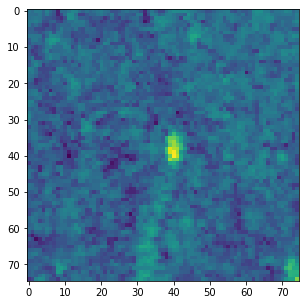

In [ ]:
#이 사진은 z축을 고려하지 않고 바로 위에서만 바라본 그림이다. 
plt.imshow(band1)
plt.show()

In [ ]:
# 2D 데이터 시각화해주는 일련의 코드를 하나의 함수로 정의하는 작업
def plot_contour_2d(band1, band2, label):
    fig = tools.make_subplots(rows=1, cols=2, specs=[[{'is_3d': True}, {'is_3d':True}]])
    fig.append_trace(dict(type='surface', z=band1, colorscale='RdBu_r',
                          scene='scene1', showscale=False), 1, 1)
    fig.append_trace(dict(type='surface', z=band2, colorscale='RdBu_r',
                          scene='scene2', showscale=False), 1, 2)
    
    fig['layout'].update(title='3D surface plot for "{}" (left is from band1, right is from band2)'.format(label), titlefont=dict(size=30), height=800, width=1200)

    py.iplot(fig)
    
    #여기 밑에 부분은 z축 없이 위에서 보는 부분 보여주는 코드
    fig, ax = plt.subplots(1,2,figsize=(16,10))
    ax[0].imshow(X_band_1[num,:,:])
    ax[0].set_title('Image from band_1', fontsize=15)
    ax[1].imshow(X_band_2[num,:,:])
    ax[1].set_title('Image from band_2', fontsize=15)
    plt.show()

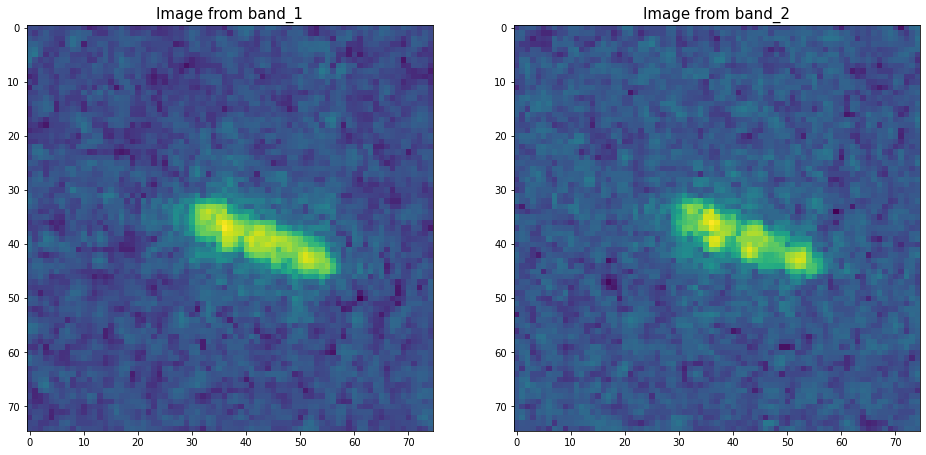

In [ ]:
# 전형적인 Ship 데이터의 시각화
num = 100
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else'ship'
plot_contour_2d(X_band_1[num,:,:], X_band_2[num,:,:], label)

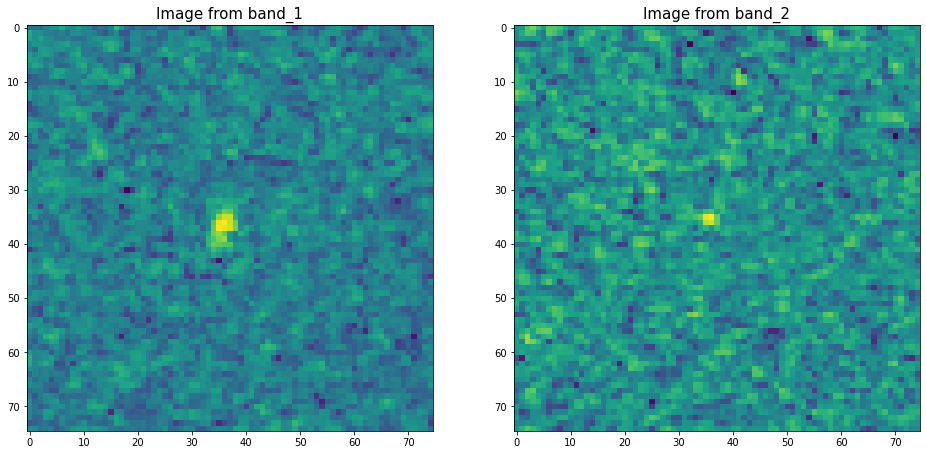

In [ ]:
# 전형적인 Iceberg 데이터의 시각화
num = 2
label = 'iceberg' if (train['is_iceberg'].values[num] == 1) else'ship'
plot_contour_2d(X_band_1[num,:,:], X_band_2[num,:,:], label)
# 주위에 바다가 아닌 작은 빙하들이 많아 노이즈가 많은 것을 알 수 있다

### 딥러닝 모델 학습 시작

In [ ]:
#tensorflow, keras 패키지가 설치되어있지 않다면 keras, tensorflow 설치 (코랩에는 기본적으로 지원)
# !pip install keras
# !pip install tensorflow

#Import Keras.
from matplotlib import pyplot
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Dense, Dropout, Input, Flatten, Activation
from keras.layers import GlobalMaxPooling2D
from keras.layers.normalization import batch_normalization
from keras.layers.merge import Concatenate
from keras.models import Model
from keras import initializers
from tensorflow.keras.optimizers import Adam
from keras.callbacks import ModelCheckpoint, Callback, EarlyStopping

#### 딥러닝이란?
![DL_Explanation](img/what_is_DL.png)
학습을 진행할 때 몇개의 층을 만드는데, 각 층마다 뉴런들이 존재한다. 그리고 각 뉴런들은 자신에게 들어온 신호를 가중치와 곱해 모두 더하고, 역치와 비교해서 신호를 다음 층의 뉴런으로 전달하는 방법이다. 3개 이상의 레이어를 쌓으면 딥러닝이라고 한다.

#### 우리가 만들 모델의 전체적인 구조
![DL_model_struct](img/CNN_overall_structure2.png)

#### CNN(convolutional neural network)란?
<br>
CNN은 인간의 시신경 구조를 모방해 만들어진 인공신경망 알고리즘이다. 다수의 Convolutional Layer(필터)로 부터 특징맵(Feature map)을 추출하고 서브샘플링(Subsampling)을 통해 차원을 축소하여 특징맵에서 중요한 부분만을 가져온다.
<br>
<br>

#### Conv2D의 특징
![CNN_explanation](img/CNN_explanation.png)
<br>
1. Convolution Filiter을 이용하여 이미지의 특징을 추출 (이때 하나만 만드는 것이 아니라 여러 개의 filter을 이용하여 여러 특징을 추출)
2. filter는 학습된 weight 값으로 보통 크기(ex. 3 X 3)만 지정함
3. 한칸씩 위치를 옮겨가며 특징을 추출한다고 함
<br>
<br>

#### MaxPooling이란?
![Max_Pooling](img/max_pooling_example.png)
<br>
Convolution Layer에서는 한 칸씩 움직였다면 이번엔 두 칸씩 움직이며 해당 영역의 특징 값 중 최대값으로 기록한다. 사용하는 이유는 다음과 같음:
<br>
1. input size를 줄임. : 여러번 convolution layer을 반복하게 되는데, 별로 필요하지 않은 자료까지 전부를 다 분석할 필요가 없다. 특징만 뽑아내서, 학습하는 것이 합리적이지 않겠는가?
<br>
2. overfitting을 조절 : input size가 줄어드는 것은 그만큼 쓸데없는 parameter의 수가 줄어드는 것이라고 생각할 수 있다. 훈련데이터에만 높은 성능을 보이는 과적합(overfitting)을 줄일 수 있다.
<br>
3. 특징을 잘 뽑아냄. : pooling을 했을 때, 특정한 모양을 더 잘 인식할 수 있음.
<br>
<br>

#### + 이 외에 사용된 다른 레이어
Dense : 딥러닝의 가장 기본적인 레이어로써 입력과 출력을 모두 연결해주며, 입출력을 각각 연결해주는 가중치를 포함하고 있다
<br>
Activation : Dense 레이어에서는 보통 신호에 가중치를 곱하는 선형적인 방식으로 연결하지만, Activation 함수를 사용하면 sigmoid, tanh등 다른 방법으로 연결 가능하다.
<br>
Dropout : Overfitting을 방지하기 위한 레이어이며 hidden layer의 일부 유닛이 동작하지 않게 하는 방법
<br>
Flatten : 다차원의 입력 tensor을 1-차원으로 변경해주는 레이어
<br>

In [ ]:
#Building a sequential model
model=Sequential()

In [ ]:
#define our model
def getModel():
    #Inifializing a model
    gmodel=Sequential()
    
    #Conv Layer 1
    gmodel.add(Conv2D(64, kernel_size=(3, 3),activation='relu', input_shape=(75, 75, 3)))
        # 첫번째 인자 : convolution filter의 수 = 연결되어있는 뉴런의 수
        # kernel_size(a, b) : convolution kernel의 (행, 열)
        # activation : 활성화 함수 설정
            #'relu' : 0보다 값이 작으면 0을 반환하고, 0보다 큰 값이 나오는 경우 그 값을 그대로 반환하는 함수
        # input_shape() : 입력 데이터의 차원. 우리는 75 X 75 2차원에 컬러사진(RGB) 데이터이니 (75, 75, 3)
    gmodel.add(MaxPooling2D(pool_size=(3, 3), strides=(2, 2)))
        # pool_size : input을 두 공간 차원에 대해 반으로 축소합니다
        # strides : 몇칸씩 움직이는 지
    gmodel.add(Dropout(0.2))

    #Conv Layer 2
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu' ))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 3
    gmodel.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Conv Layer 4
    gmodel.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
    gmodel.add(MaxPooling2D(pool_size=(2, 2), strides=(2, 2)))
    gmodel.add(Dropout(0.2))

    #Flatten the data for upcoming dense layers
    gmodel.add(Flatten())

    #Dense Layers
    gmodel.add(Dense(512))
    gmodel.add(Activation('relu')) 
    gmodel.add(Dropout(0.2))

    #Dense Layer 2
    gmodel.add(Dense(256))
    gmodel.add(Activation('relu'))
    gmodel.add(Dropout(0.2))

    #Sigmoid Layer
    #Adam 은 모델을 최적화 시켜주는 기능을 한다, 
    gmodel.add(Dense(1))
    gmodel.add(Activation('sigmoid'))

    mypotim=Adam(lr=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-08, decay=0.0)
    gmodel.compile(loss='binary_crossentropy',
                  optimizer=mypotim,
                  metrics=['accuracy'])
    gmodel.summary()
    return gmodel

def get_callbacks(filepath, patience=2):
    es = EarlyStopping('val_loss', patience=patience, mode="min") # Overfitting 방지하려고 쓰는 함수
    msave = ModelCheckpoint(filepath, save_best_only=True) # best model configuration을 msave에 저장해준다
    return [es, msave]
file_path = ".model_weights.hdf5"
callbacks = get_callbacks(filepath=file_path, patience=5)
# 5개의 epoch(patience=5)동안 loss가 Minimize 안되면 학습을 멈추고 CheckPoint로 다시 돌아간다

In [ ]:
# 더 나은 모델을 위하여 바로 test하는 것이 아니라 train set, validation set으로 나눠서 먼저 모델을 평가
target_train = train['is_iceberg']
X_train, X_valid, y_train, y_valid = train_test_split(X_train, target_train, random_state=1, train_size = 0.8)

In [ ]:
# 일관성있게 모델 성능을 평가하기 위해 랜덤 시드 값 고정
import tensorflow as tf

SEED = 2021
np.random.seed(SEED)
tf.random.set_seed(SEED)

In [ ]:
gmodel=getModel() # gmodel에 미리 만들어두었던 모델을 생성 및 저장
gmodel.fit(X_train, y_train,
          batch_size=24, # 몇 개의 샘플로 가중치를 갱신할 것인지 설정
          epochs=10, # 전체 데이터셋을 몇 번 반복 학습할지 설정
          verbose=1,
          validation_data=(X_valid, y_valid),
          callbacks=callbacks) # 모델 학습 시작


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 73, 73, 64)        1792      
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 36, 36, 64)        0         
_________________________________________________________________
dropout (Dropout)            (None, 36, 36, 64)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 34, 34, 128)       73856     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 17, 17, 128)       0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 17, 17, 128)       0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 15, 15, 128)      

In [ ]:
hist = gmodel.history
hist.history['val_loss']

[0.5923157930374146,
 0.5644187331199646,
 0.4758347272872925,
 0.47518667578697205,
 0.4446885585784912,
 0.3814687728881836,
 0.4007549285888672,
 0.36991602182388306,
 0.4469122588634491,
 0.3633979558944702]

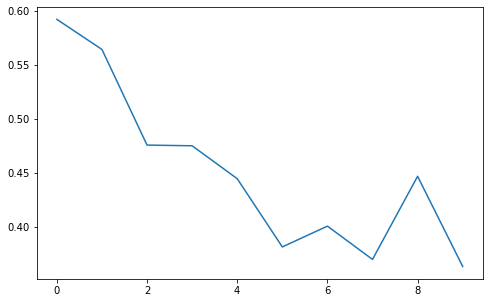

In [ ]:
plt.plot(hist.history['val_loss'])

In [ ]:
gmodel.load_weights(filepath=file_path)
score = gmodel.evaluate(X_valid, y_valid, verbose=1)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

11/11 [==============================] - 0s 40ms/step - loss: 0.3634 - accuracy: 0.8380
Test loss: 0.3633979558944702
Test accuracy: 0.8380062580108643


In [ ]:
predicted_test = gmodel.predict(X_test)

In [ ]:
predicted_test

array([[0.8380958 ],
       [0.8646189 ],
       [0.9918664 ],
       ...,
       [0.17946312],
       [0.94273657],
       [0.96859944]], dtype=float32)

In [ ]:
submission = pd.DataFrame()
submission['id']=test['id']
submission['is_iceberg']=predicted_test.reshape((predicted_test.shape[0]))
submission.to_csv('sub.csv', index=False)